# Exploratary Data Analysis 1

## Hourly demand and borough

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sbs
import geopandas as gpd
import folium 
from folium.plugins import HeatMap


In [2]:
# Load the Parquet file into a Pandas DataFrame
clean_df = pd.read_parquet("../data/curated/merged_data/first_cleaned.parquet/")


In [3]:
# Set display options to show all columns
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.expand_frame_repr', False)  # Prevent line breaks in the output

# Get summary statistics for all columns, including non-numerical ones
summary_stats = clean_df.describe(include='all')

# Display the summary statistics
print(summary_stats)

       pickup_date   pickup_hour  PUBorough  hourly_trip_count           CIG           WND           VIS           TMP           DEW           SLP  Number of Events
count        23635  23635.000000      23635       23635.000000  23635.000000  23635.000000  23635.000000  23635.000000  23635.000000  23635.000000      23635.000000
unique         184           NaN          6                NaN           NaN           NaN           NaN           NaN           NaN           NaN               NaN
top     2023-09-18           NaN  Manhattan                NaN           NaN           NaN           NaN           NaN           NaN           NaN               NaN
freq           354           NaN       6063                NaN           NaN           NaN           NaN           NaN           NaN           NaN               NaN
mean           NaN     11.397884        NaN         922.417686  11392.383270      2.589865   1271.613522     17.353392     11.623652   1015.997972        182.539454
std       

In [4]:
# extract a month column from the pickup_datet column
clean_df['pickup_month'] = pd.to_datetime(clean_df['pickup_date']).dt.month

In [5]:
# check what features are available
print(clean_df.columns)

Index(['pickup_date', 'pickup_hour', 'PUBorough', 'hourly_trip_count', 'CIG',
       'WND', 'VIS', 'TMP', 'DEW', 'SLP', 'Number of Events', 'pickup_month'],
      dtype='object')


### Hourly demand

In [6]:
# Group by 'pickup_hour' and 'PUBorough' to get the sum of trips and average weather data
hourly_demand = clean_df.groupby(['pickup_hour', 'PUBorough']).agg({
    'hourly_trip_count': 'sum',
    'TMP': 'mean',
    'VIS': 'mean',
    'Number of Events': 'sum'
}).reset_index()

# Rename the columns to match the desired output
hourly_demand.rename(columns={
    'hourly_trip_count': 'total_hourly_trips',
    'TMP': 'avg_temperature',
    'VIS': 'avg_visibility',
    'Number of Events': 'total_events'
}, inplace=True)

# Round the average temperature and visibility to 1 decimal place
hourly_demand['avg_temperature'] = hourly_demand['avg_temperature'].round(1)
hourly_demand['avg_visibility'] = hourly_demand['avg_visibility'].round(1)

# Show the first 10 rows of the aggregated result
print(hourly_demand.head(5))

   pickup_hour  PUBorough  total_hourly_trips  avg_temperature  avg_visibility  total_events
0            0      Bronx                 238             18.7          1364.5           105
1            0   Brooklyn                4157             17.3          1360.1          6720
2            0        EWR                   1             21.7          1609.3             0
3            0  Manhattan              466188             17.3          1358.6         71372
4            0     Queens               69249             17.3          1358.6          3924


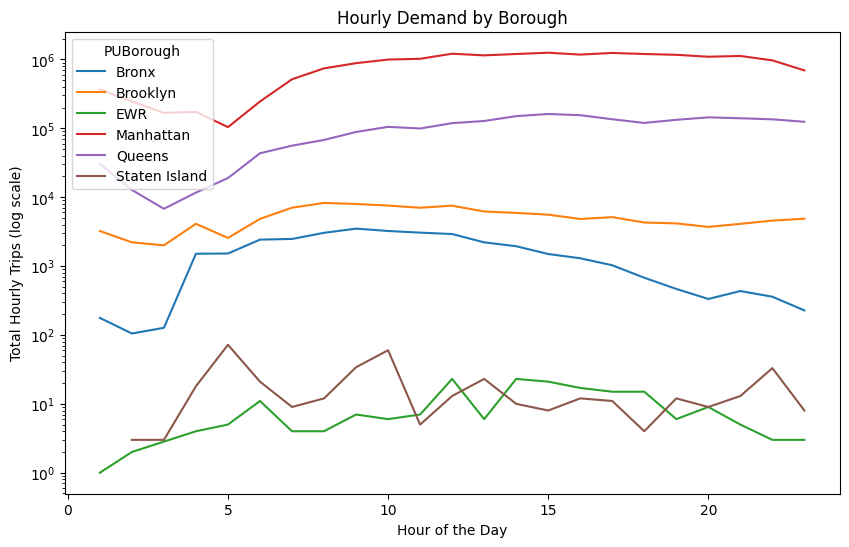

In [7]:
# plot hourly demand for each borough log scale
fig, ax = plt.subplots(figsize=(10, 6))
sbs.lineplot(data=hourly_demand[hourly_demand['pickup_hour'] != 0], x='pickup_hour', y='total_hourly_trips', hue='PUBorough', ax=ax)
ax.set_yscale('log')
ax.set_title('Hourly Demand by Borough')
ax.set_xlabel('Hour of the Day')
ax.set_ylabel('Total Hourly Trips (log scale)')
plt.show()

In [8]:
# identify which hour has the highest demand for each borough, can't be hour 0
max_demand_hour = hourly_demand[hourly_demand['pickup_hour'] > 0].groupby('PUBorough')['total_hourly_trips'].idxmax()
max_demand_hour = hourly_demand.loc[max_demand_hour, ['PUBorough', 'pickup_hour', 'total_hourly_trips']]
print(max_demand_hour)


        PUBorough  pickup_hour  total_hourly_trips
52          Bronx            9                3497
47       Brooklyn            8                8250
72            EWR           12                  23
91      Manhattan           15             1251129
92         Queens           15              161365
33  Staten Island            5                  72


## Distribution Analysis 

In [9]:
# Step 1: Load the shapefile of NYC boroughs
gdf = gpd.read_file("../data/landing/external/geo_export_f16e615f-62c7-40bb-856c-2cccde28f16b.shp")

# Convert to GeoJSON
geojson_data = gdf.to_json()

# Check the first 5 rows of the GeoDataFrame
gdf.head(5)


,borough,location_i,objectid,shape_area,shape_leng,zone,geometry
0,EWR,1.0,1.0,0.000782,0.116357,Newark Airport,"POLYGON ((-74.18445 40.695, -74.18449 40.69509..."
1,Queens,2.0,2.0,0.004866,0.433470,Jamaica Bay,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ..."
2,Bronx,3.0,3.0,0.000314,0.084341,Allerton/Pelham Gardens,"POLYGON ((-73.84793 40.87134, -73.84725 40.870..."
3,Manhattan,4.0,4.0,0.000112,0.043567,Alphabet City,"POLYGON ((-73.97177 40.72582, -73.97179 40.725..."
4,Staten Island,5.0,5.0,0.000498,0.092146,Arden Heights,"POLYGON ((-74.17422 40.56257, -74.17349 40.562..."


In [10]:
# Total hourly trips by borough
agg_data = clean_df.groupby('PUBorough').agg({
    'hourly_trip_count': 'sum'
}).reset_index()

# Rename the columns to match the desired output
agg_data.rename(columns={'PUBorough': 'borough', 'hourly_trip_count': 'total_hourly_trips'}, inplace=True)

# Ensure the data is in the correct format by selecting only the relevant columns
agg_data = agg_data[['borough', 'total_hourly_trips']]

# Display the first 5 rows of the aggregated data
agg_data.head(610)


,borough,total_hourly_trips
0,Bronx,34794
1,Brooklyn,121837
2,EWR,198
3,Manhattan,19389574
4,Queens,2254545
5,Staten Island,394


### Hourly Trips by Borough

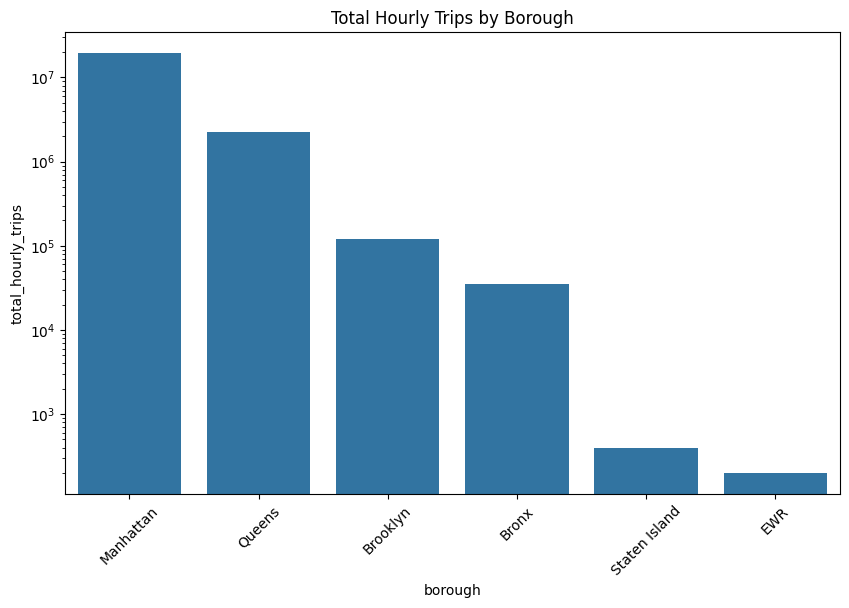

In [11]:
# Sort the DataFrame by 'total_hourly_trips' in descending order
agg_data_sorted = agg_data.sort_values(by='total_hourly_trips', ascending=False)

# Create a bar chart with a log scale
fig, ax = plt.subplots(figsize=(10, 6))

# Create the bar plot using Seaborn
sbs.barplot(x='borough', y='total_hourly_trips', data=agg_data_sorted, ax=ax)

# Set the y-axis to a logarithmic scale
ax.set_yscale('log')

# Set the title of the plot
ax.set_title('Total Hourly Trips by Borough')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()

In [12]:
# save the plot
fig.savefig("../plots/total_hourly_trips_by_borough.png")

## Event distribution by borough

In [13]:
# plot event distribution by borough
agg_data_events = clean_df.groupby('PUBorough').agg({
    'Number of Events': 'sum'
}).reset_index()

In [14]:
# Rename the columns to match the expected output
agg_data_events.rename(columns={'PUBorough': 'borough', 'Number of Events': 'total_events'}, inplace=True)

         borough  total_events
0          Bronx        604582
1       Brooklyn       1148098
2            EWR             0
3      Manhattan       1541820
4         Queens        998400
5  Staten Island         21420


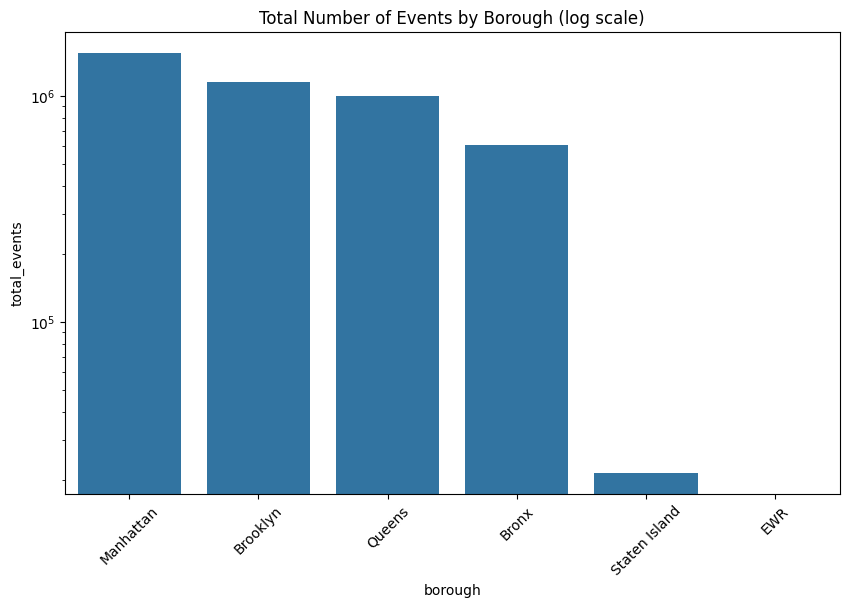

In [15]:
# Display the first 5 rows of the aggregated data
print(agg_data_events.head(6))

# Sort the DataFrame by 'total_events' in descending order
agg_data_events_sorted = agg_data_events.sort_values(by='total_events', ascending=False)

# Create a bar chart for the total number of events by borough
fig, ax = plt.subplots(figsize=(10, 6))

# Create the bar plot using Seaborn with log scale
sbs.barplot(x='borough', y='total_events', data=agg_data_events_sorted, ax=ax)

# Set the y-axis to a logarithmic scale
ax.set_yscale('log')

# Set the title of the plot
ax.set_title('Total Number of Events by Borough (log scale)')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()


In [16]:
# save the plot
fig.savefig("../plots/total_events_by_borough.png")

## Correlation Analysis 

In [17]:
# Calculate correlations for hourly trip count
temp_hourly_corr = clean_df['TMP'].corr(clean_df['hourly_trip_count'])
vis_hourly_corr = clean_df['VIS'].corr(clean_df['hourly_trip_count'])
events_hourly_corr = np.log1p(clean_df['Number of Events']).corr(clean_df['hourly_trip_count'])

# Create a DataFrame to hold the correlation results
correlation_matrix = pd.DataFrame({
    'Correlation': ['temp_hourly_corr', 'vis_hourly_corr', 'events_hourly_corr'
                ],
    'Value': [temp_hourly_corr, vis_hourly_corr, events_hourly_corr, 
              ]
})

# Display the correlation matrix
print(correlation_matrix)


          Correlation     Value
0    temp_hourly_corr -0.003383
1     vis_hourly_corr  0.030263
2  events_hourly_corr  0.277585


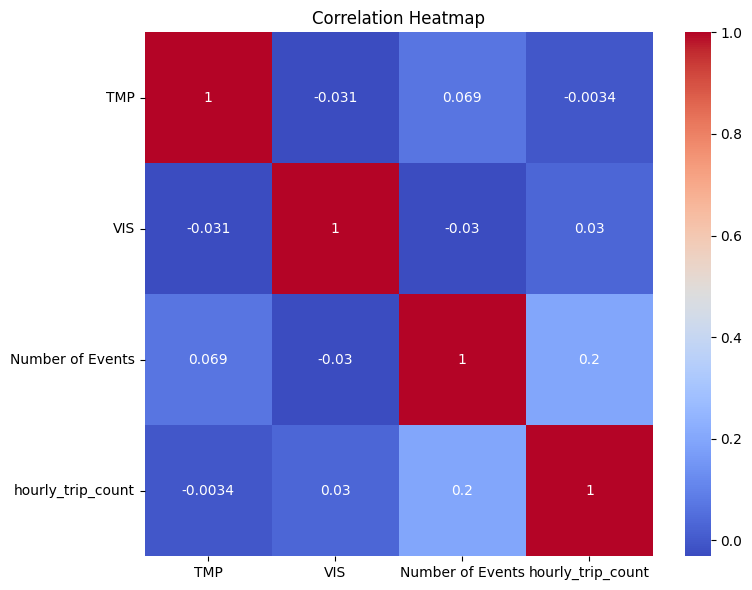

In [18]:
# plot heat map for weather and number of trips
# Create a heatmap of the correlation matrix
plt.figure(figsize=(8, 6))
sbs.heatmap(clean_df[['TMP', 'VIS', 'Number of Events', 'hourly_trip_count']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.tight_layout()

## Bivariate Analysis

### Events over dates

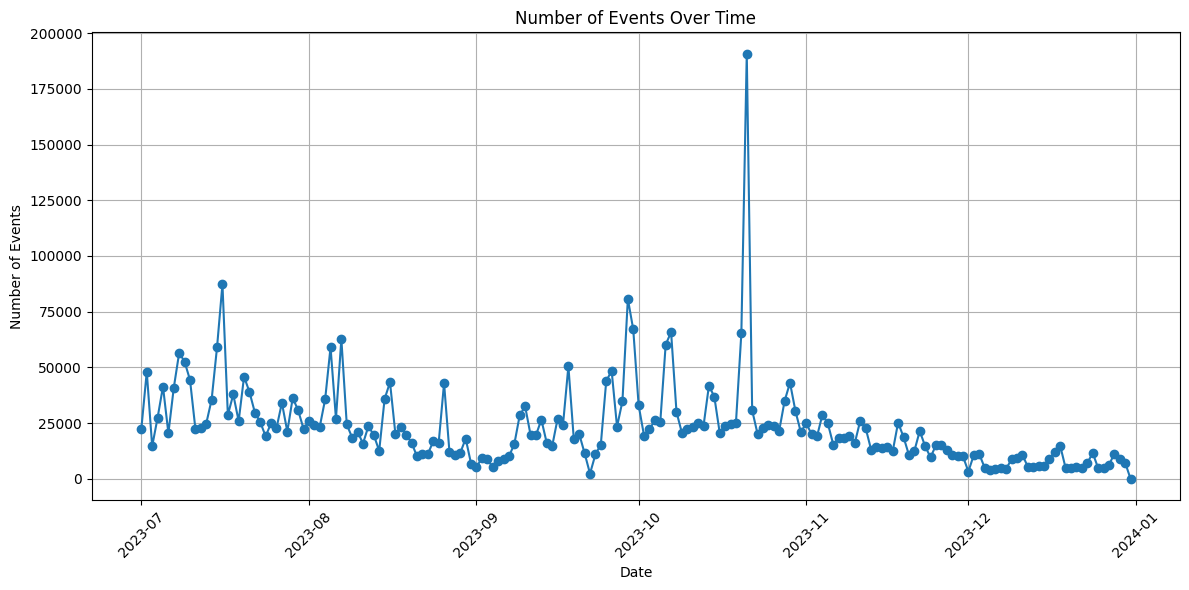

In [19]:
# Convert 'pickup_date' to datetime and extract just the date part if not already done
clean_df['Event Date'] = pd.to_datetime(clean_df['pickup_date']).dt.date

# Group by 'Event Date' and count the number of events
events_per_date_df = clean_df.groupby('Event Date').agg({'Number of Events': 'sum'}).reset_index()

# Plot the date vs number of events
plt.figure(figsize=(12, 6))
plt.plot(events_per_date_df['Event Date'], events_per_date_df['Number of Events'], marker='o', linestyle='-')
plt.title('Number of Events Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Events')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
# Save the plot as a PNG file
plt.savefig('../plots/number_of_events_over_time.png')
# Show the plot
plt.show()


In [20]:
# identify the top 5 days with most events
top_5_days = events_per_date_df.nlargest(5, 'Number of Events')
print(top_5_days)

     Event Date  Number of Events
112  2023-10-21            190788
15   2023-07-16             87312
90   2023-09-29             80760
91   2023-09-30             67006
98   2023-10-07             65809


### Events for each day of week

In [21]:
# plot the number of events per day of the week
# Convert the 'Event Date' to a datetime object
clean_df['Event Date'] = pd.to_datetime(clean_df['Event Date'])

In [22]:
# Extract the day of the week from the 'Event Date'
clean_df['Day of Week'] = clean_df['Event Date'].dt.day_name()

In [23]:
# Group by 'Day of Week' and count the number of events
events_per_day_df = clean_df.groupby(['Day of Week', "pickup_month"]).agg({'Number of Events': 'sum'}).reset_index()

/var/folders/gf/ml3nsztn0cb376sq34z0ll1r0000gn/T/ipykernel_23802/3718613571.py:16: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  sbs.lineplot(x='Day of Week', y='Number of Events', data=events_per_day_df, hue='pickup_month', palette=palette, sort=True)


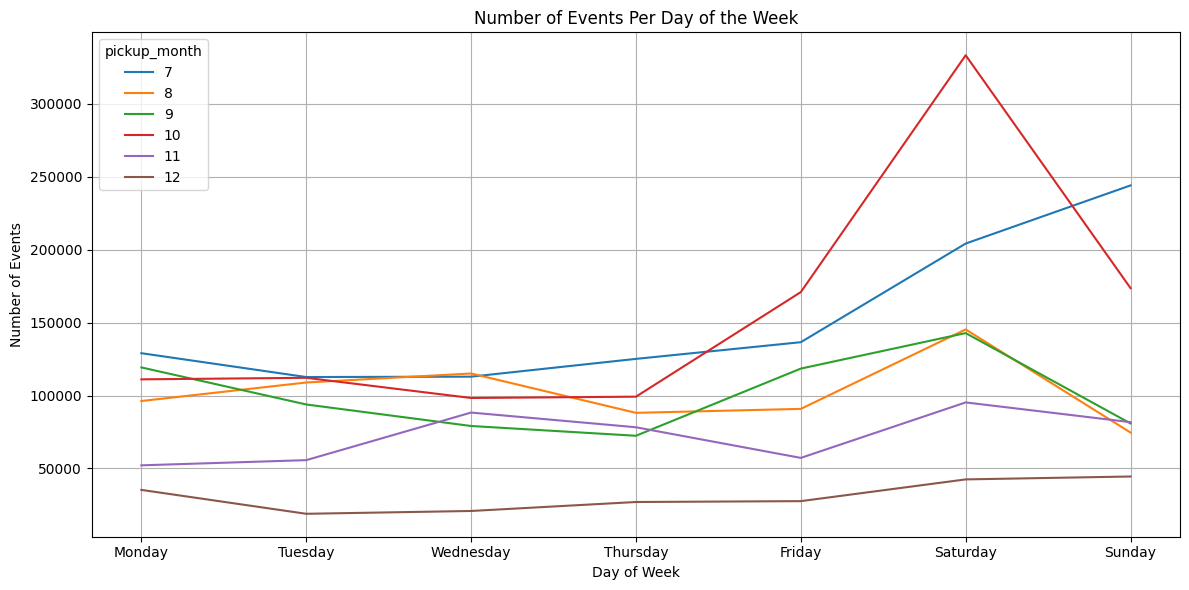

In [24]:
import seaborn as sbs
import matplotlib.pyplot as plt
import pandas as pd

# Define the order of the days of the week
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Convert 'Day of Week' to a categorical type with the specified order
events_per_day_df['Day of Week'] = pd.Categorical(events_per_day_df['Day of Week'], categories=days_order, ordered=True)

# Define a color palette
palette = sbs.color_palette("tab10")  # Or use any other palette like 'husl', 'coolwarm', etc.

# Plot the number of events per day of the week
plt.figure(figsize=(12, 6))
sbs.lineplot(x='Day of Week', y='Number of Events', data=events_per_day_df, hue='pickup_month', palette=palette, sort=True)
plt.title('Number of Events Per Day of the Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Events')
plt.grid(True)
plt.tight_layout()
plt.savefig('../plots/number_of_events_per_day_of_week.png')
plt.show()


In [25]:
# plot hourly demand for day of the week
# Group by 'pickup_hour' and 'Day of Week' to get the sum of trips and average weather data
hourly_demand_day = clean_df.groupby(['pickup_hour', 'Day of Week']).agg({
    'hourly_trip_count': 'sum',
    'TMP': 'mean',
    'VIS': 'mean',
    'Number of Events': 'sum'
}).reset_index()


In [26]:
# Rename the columns to match the desired output
hourly_demand_day.rename(columns={
    'hourly_trip_count': 'total_hourly_trips',
    'TMP': 'avg_temperature',
    'VIS': 'avg_visibility',
    'Number of Events': 'total_events'
}, inplace=True)

In [27]:
# Round the average temperature and visibility to 1 decimal place
hourly_demand_day['avg_temperature'] = hourly_demand_day['avg_temperature'].round(1)
hourly_demand_day['avg_visibility'] = hourly_demand_day['avg_visibility'].round(1)


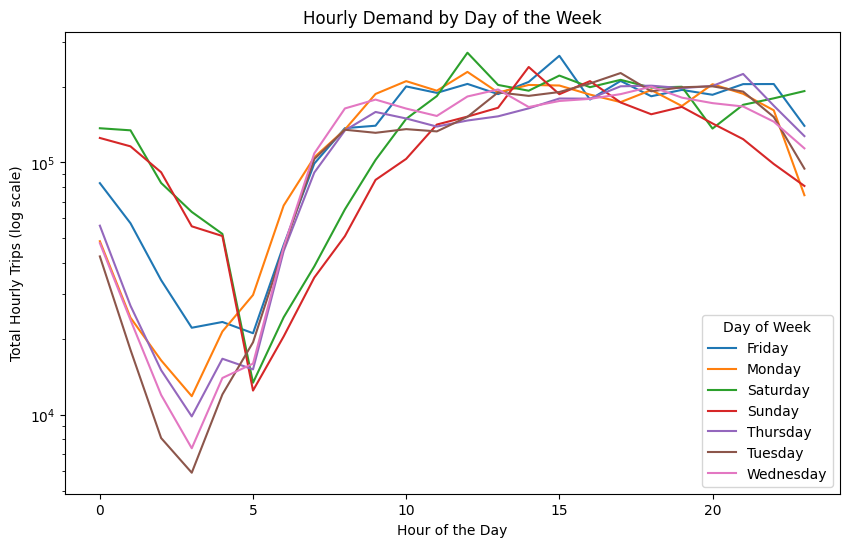

In [28]:
# Plot hourly demand for each day of the week
fig, ax = plt.subplots(figsize=(10, 6))
sbs.lineplot(data=hourly_demand_day, x='pickup_hour', y='total_hourly_trips', hue='Day of Week', ax=ax)
ax.set_yscale('log')
ax.set_title('Hourly Demand by Day of the Week')
ax.set_xlabel('Hour of the Day')
ax.set_ylabel('Total Hourly Trips (log scale)')
plt.show()